# 0. Check required versions of icechunk and xarray are installed

In [1]:
#!pip install git+https://github.com/zarr-developers/VirtualiZarr.git@ab/upgrade-icechunk#egg=VirtualiZarr[icechunk]
!pip list | grep -E '^(virtualizarr|icechunk|zarr|xarray)\s'

icechunk                  0.1.0a12
virtualizarr              1.2.0
xarray                    2025.1.1
zarr                      3.0.1


In [2]:
import fsspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import zarr

import helpers

# 1. Set zarr runtime configuration

Async and threading operations can be set via zarr.config. 

* `async.concurrency` controls how many chunks can be fetched asynchronously at once.
* `threading.max_workers` determines how many threads handle the decompression or processing of those fetched chunks.

From some adhoc testing, it looks like CPU is saturated at `async.concurrency = ~30` and `threading.max_workers` makes no impact. The default setting for `threading.max_workers` is `None` so presumably this uses all threads available?

In [3]:
zarr.config.set({
    'async': {'concurrency': 100, 'timeout': None},
    'threading': {'max_workers': None}
})

# 2. Initialize the repo

In [4]:
repo = helpers.find_or_create_icechunk_repo(
    store_name="MUR-JPL-L4-GLOB-v4.1-virtual-v3",
    store_type="s3",
    overwrite=False
)
session = repo.readonly_session(branch="main")

# 3. Read and plot the data with xarray

In [5]:
%%time
xds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)

/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcode

CPU times: user 11.5 s, sys: 2.7 s, total: 14.2 s
Wall time: 24.4 s


In [13]:
%%time
data = xds.analysed_sst.sel(lat=slice(48, 49), lon=slice(-125, -124)).mean(["lat", "lon"]).load()

CPU times: user 3min 4s, sys: 24.9 s, total: 3min 29s
Wall time: 1min 44s


CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 15.1 ms


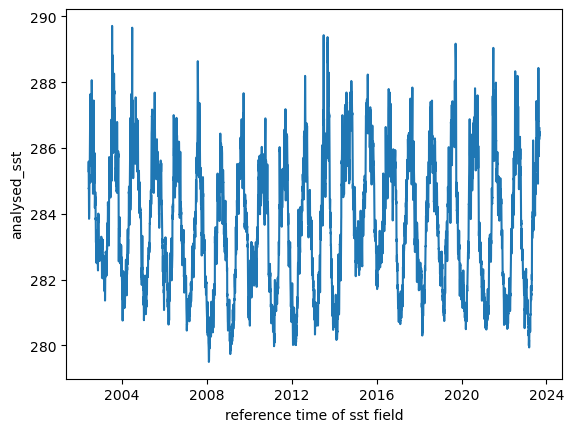

In [14]:
%%time
data.plot()

# 4. Read and plot the data with zarr-python

In [15]:
%%time
# Open Zarr store
zarr_store = zarr.open(session.store, mode="r")

CPU times: user 3.05 ms, sys: 429 μs, total: 3.47 ms
Wall time: 2.06 ms


In [16]:
lat_range = [48,49]
lat_min = -90
lon_range = [-125,-124]
lon_min = -180
resolution = 0.01
lat_indices = [int((lat - lat_min)/resolution) for lat in lat_range]
lon_indices = [int((lon - lon_min)/resolution) for lon in lon_range]
lat_indices, lon_indices

([13800, 13900], [5500, 5600])

In [17]:
%%time
sst_subset = zarr_store["analysed_sst"][:, lat_indices[0]:lat_indices[1], lon_indices[0]:lon_indices[1]]
sst_mean = np.mean(sst_subset, axis=(1, 2))

/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


CPU times: user 2min 50s, sys: 23.7 s, total: 3min 14s
Wall time: 35.9 s


In [18]:
print(f"Fetched {'{:,}'.format(np.prod(sst_subset.shape))} points")

Fetched 77,660,000 points


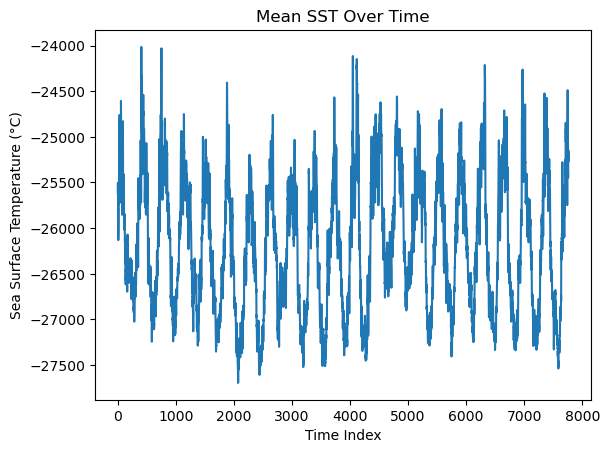

CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 140 ms


In [19]:
%%time
plt.plot(sst_mean)
plt.title("Mean SST Over Time")
plt.xlabel("Time Index")
plt.ylabel("Sea Surface Temperature (°C)")  # Replace with correct units
plt.show()